# Data and Setup

In [1]:
%%capture
# Importing required libraries
import pandas as pd
import numpy as np

# Viz libraries and style setting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Set the palette to the "pastel" default palette:
sns.set_palette("pastel")

In [2]:
lgCan = pd.read_csv('https://raw.githubusercontent.com/Kenyaokun/Practicum_IBM/main/3.28%20-%204.04%20Update/lung_cancer_all_dummified.csv')

In [3]:
lgCan

,Study ID,Cancer Type Detailed,Sex,Age,Smoking Status,Mutation Count,Fraction Genome Altered,Overall Survival Status,Overall Survival (Months)
0,1,1,0,70,0,0,0.4565,0,0.00
1,1,1,0,81,0,0,0.0000,0,23.98
2,1,1,0,67,0,289,0.2221,0,50.03
3,1,1,1,79,0,0,0.2362,1,3.98
4,1,1,0,68,0,1272,0.0854,0,19.94
...,...,...,...,...,...,...,...,...,...
2559,3,1,1,75,1,211,0.2382,1,43.91
2560,3,1,0,63,1,101,0.5420,1,8.59
2561,3,1,1,71,1,216,0.4405,1,11.18
2562,3,2,1,68,1,109,0.0598,0,4.00


# Preparing Data 

In [4]:
# Standardizing Column names
lgCan.columns = lgCan.columns.str.replace(' ', '_') # replacing spaces (' ') with  underscore.
lgCan.columns = lgCan.columns.str.replace('-', '_') # replacing hyphens ('-') with underscore
lgCan.columns = lgCan.columns.str.replace('(', '') # Removing '('
lgCan.columns = lgCan.columns.str.replace(')', '') # Removing ')'
lgCan.columns= lgCan.columns.str.lower() # converting column names to lower case

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


In [5]:
# Dropping unwanted columns - Creating data for Survival Classification 
lgCanClf = lgCan.drop(['study_id','overall_survival_months'], axis = 1)

# Dropping unwanted columns - Creating data for Survival Time prediction  
lgCanReg = lgCan.drop(['study_id','overall_survival_status'], axis = 1)

# Random Forest

In [6]:
from sklearn.model_selection import train_test_split

y = lgCanClf['overall_survival_status'] 
X = lgCanClf.loc[:, lgCanClf.columns != 'overall_survival_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [18]:
from sklearn.ensemble import RandomForestClassifier
print(RandomForestClassifier().fit(X_train, y_train).score(X_test, y_test))

0.8350649350649351


In [43]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV

# Creating a parameters grid

param_grid = { 
    'bootstrap': [True, False],
    'n_estimators': [150,100],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth' : [12,15,18],
    'min_samples_leaf': [1, 2,5],
    'min_samples_split': [2,5],
    'n_jobs': [-1]
}

# Model Definition
rfModel = RandomForestClassifier()

#  
rfModelGrid = GridSearchCV(rfModel, param_grid=param_grid, cv=5)

# Use meta model methods to fit score and predict model:
rfModelGrid.fit(X_train, y_train)

CPU times: user 6min 42s, sys: 30.6 s, total: 7min 13s
Wall time: 9min 28s


In [44]:
#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(rfModelGrid.best_score_))
print("best parameters: {}".format(rfModelGrid.best_params_))
print("test-set score: {:.3f}".format(rfModelGrid.score(X_test, y_test)))

best mean cross-validation score: 0.812
best parameters: {'bootstrap': True, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'n_jobs': -1}
test-set score: 0.840


In [61]:
import joblib

# Getting the model with best parameters based on gridsearch tuning of hyperparameters
tuned_rfModelGrid = rfModelGrid.best_estimator_

# Saving the model 
joblib.dump(tuned_rfModelGrid, "/TunedRfClf.joblib")

['./TunedRfClf.joblib']

# LightGBM

In [34]:
from lightgbm import LGBMClassifier

In [40]:
%%time
lgbm_params = {
    'boosting_type': ['gbdt', 'rf', 'dart', 'goss'],
    'num_leaves': [2,9,13,15],
    'learning_rate': [0.1,0.8, 1.0],
    'max_depth': [-1,2,20,25,30],
    'n_estimators': [100,150,200],
}

lgbm_grid = GridSearchCV(LGBMClassifier(random_state=42), lgbm_params, cv=5)
lgbm_grid.fit(X_train, y_train)

CPU times: user 9min 45s, sys: 15 s, total: 10min
Wall time: 2min 42s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
900 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 744, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 544, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    b

In [42]:
#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(lgbm_grid.best_score_))
print("best parameters: {}".format(lgbm_grid.best_params_))
print("test-set score: {:.3f}".format(lgbm_grid.score(X_test, y_test)))

best mean cross-validation score: 0.818
best parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.8, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 15}
test-set score: 0.845


# Survival Modeling - Voting Classifier

In [41]:
from sklearn.model_selection import train_test_split

y = lgCanClf['overall_survival_status'] 
X = lgCanClf.loc[:, lgCanClf.columns != 'overall_survival_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [42]:
# Build multiple classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Generally works better if models you choose have diverse methodological approaches...

log_clf = LogisticRegression(random_state=42) # logistic regression w/ C=default
rnd_clf = RandomForestClassifier(random_state=42) # Random Forest
svm_clf = SVC(random_state=42) # support vector machine

In [22]:
# Goal is to predict ytest for each model and then use PREDICTIONS FROM EACH MODEL to select final predictions

# Need to set up a standard for selecting final prediction:
from sklearn.ensemble import VotingClassifier

# Estimators arg is giving each estimator a name for references in functions like GridsearchCV

# voting='hard' takes majority vote of each predicted value to select final prediction for ytest

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard') 

In [23]:
vmodel = voting_clf.fit(X_train, y_train)
print(vmodel.score(X_test, y_test)) #return accuracy of voting classifier

0.7324675324675325


In [24]:
# Compare to accuracy of individual models...
log_clf = LogisticRegression(random_state=42) # logistic regression w/ C=default
rnd_clf = RandomForestClassifier(random_state=42) # Random Forest
svm_clf = SVC(random_state=42) # support vector machine


print(log_clf.fit(X_train, y_train).score(X_test, y_test))
print(rnd_clf.fit(X_train, y_train).score(X_test, y_test))
print(svm_clf.fit(X_train, y_train).score(X_test, y_test))

0.7324675324675325
0.8363636363636363
0.7324675324675325


In [25]:
# 'soft' voting takes the predicted probabilities of each model and choose the highest value#
#Need to ensure that probabilities are generated in each model...

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [26]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft') 

vmodel = voting_clf.fit(X_train, y_train)

In [27]:
print(vmodel.score(X_test, y_test)) #return accuracy of voting classifier


0.7467532467532467


# Neural network

In [35]:
from sklearn.metrics import accuracy_score
import tensorflow as tf

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3, Xception

In [36]:
from sklearn.model_selection import train_test_split

y = lgCanClf['overall_survival_status'] 
X = lgCanClf.loc[:, lgCanClf.columns != 'overall_survival_status']

# Splitting Data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Setting parameters
n_features = X_train.shape[1]
n_class = len(np.unique(y))

In [40]:
# define the keras model
model = Sequential()
model.add(Dense(2056, input_dim=n_features, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1028, activation='relu'))
model.add(Dense(514, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(n_class, activation='softmax'))

# compile the keras model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=2)

# evaluate on test set
yhat = model.predict(X_test)
yhat = np.argmax(yhat, axis=-1).astype('int')
acc = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % acc)

Epoch 1/150
57/57 - 4s - loss: 7.8296 - 4s/epoch - 74ms/step
Epoch 2/150
57/57 - 2s - loss: 1.3807 - 2s/epoch - 33ms/step
Epoch 3/150
57/57 - 2s - loss: 0.7803 - 2s/epoch - 35ms/step
Epoch 4/150
57/57 - 3s - loss: 0.6624 - 3s/epoch - 50ms/step
Epoch 5/150
57/57 - 3s - loss: 0.9003 - 3s/epoch - 52ms/step
Epoch 6/150
57/57 - 2s - loss: 0.5755 - 2s/epoch - 33ms/step
Epoch 7/150
57/57 - 2s - loss: 0.5625 - 2s/epoch - 32ms/step
Epoch 8/150
57/57 - 2s - loss: 0.5654 - 2s/epoch - 32ms/step
Epoch 9/150
57/57 - 2s - loss: 0.5610 - 2s/epoch - 33ms/step
Epoch 10/150
57/57 - 2s - loss: 0.5772 - 2s/epoch - 33ms/step
Epoch 11/150
57/57 - 2s - loss: 0.5793 - 2s/epoch - 32ms/step
Epoch 12/150
57/57 - 2s - loss: 0.5646 - 2s/epoch - 32ms/step
Epoch 13/150
57/57 - 2s - loss: 0.5764 - 2s/epoch - 31ms/step
Epoch 14/150
57/57 - 2s - loss: 0.5748 - 2s/epoch - 32ms/step
Epoch 15/150
57/57 - 2s - loss: 0.5553 - 2s/epoch - 34ms/step
Epoch 16/150
57/57 - 2s - loss: 0.5537 - 2s/epoch - 32ms/step
Epoch 17/150
57/5

# Model Evaluation  - Tuned RF model

Reference-  [Link](https://www.ritchieng.com/machine-learning-evaluate-classification-model/)

In [54]:
# make class predictions for the testing set
y_pred_class = tuned_rfModelGrid.predict(X_test)

# store the predicted probabilities for class 1
y_pred_prob = tuned_rfModelGrid.predict_proba(X_test)[:, 1]

Text(0, 0.5, 'Frequency')

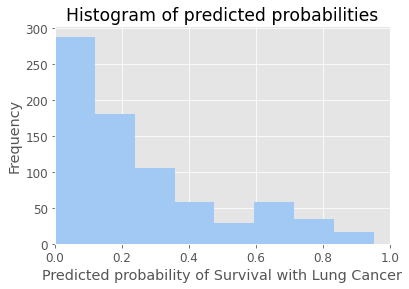

In [55]:
# histogram of predicted probabilities

# 8 bins
plt.hist(y_pred_prob, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Survival with Lung Cancer')
plt.ylabel('Frequency')

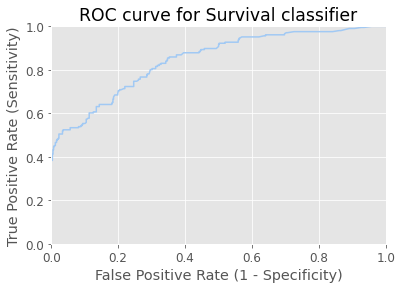

In [56]:
from sklearn import metrics
# IMPORTANT: first argument is true values, second argument is predicted probabilities

# we pass y_test and y_pred_prob
# we do not use y_pred_class, because it will give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Survival classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [57]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[539  25]
 [ 98 108]]


In [60]:
print("Precision score on the Test set: {:.3f}".format(metrics.precision_score(y_test, y_pred_class)))

Precision score on the Test set: 0.812


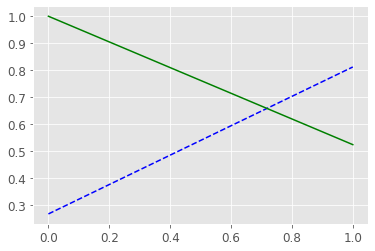

In [58]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_pred_class)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")

plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.show()
